# Counting legal moves


**TO DO**
- train model with max pooling on the binary problem, where I know it works, if possible all the way to 100% accuracy; this is a proof-of-principle showing that the model is good; maybe save intermediate versions at different accuracies?
- try to solve the counting problem using *transfer learning*: copy the convolutional layers of the solution to the previous problem, then add a different tail with average instead of max pooling (might work better if we also strip off the last conv layer, or at least its bias)

In [ ]:
from MorpionSolitaire import *
from DeepLearningMS import *

In [ ]:
from multiprocess import Pool
pool = Pool()

Process ForkPoolWorker-1:
Process ForkPoolWorker-3:
Traceback (most recent call last):
Process ForkPoolWorker-4:
Traceback (most recent call last):
Process ForkPoolWorker-2:
Traceback (most recent call last):
  File "/home/marc/anaconda3/lib/python3.8/site-packages/multiprocess/process.py", line 315, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/home/marc/anaconda3/lib/python3.8/site-packages/multiprocess/process.py", line 315, in _bootstrap
    self.run()
  File "/home/marc/anaconda3/lib/python3.8/site-packages/multiprocess/process.py", line 315, in _bootstrap
    self.run()
  File "/home/marc/anaconda3/lib/python3.8/site-packages/multiprocess/process.py", line 315, in _bootstrap
    self.run()
  File "/home/marc/anaconda3/lib/python3.8/site-packages/multiprocess/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/home/marc/anaconda3/lib/python3.8/site-packages/multiprocess/process.py", line 108, in run
    self._target(*self

## Mini-batches

This function plays one game at random until there are no more moves, then rewinds the game to an arbitrary interemediate stage, and returns the final grid.

When the score of the game played is $n$, the probability to rewind by $i$ steps ($i$ between 1 and $n$) is given by:
$$
    p_i = \frac{6 (n-i)^2}{n (n+1) (2n+1)}
$$
i.e. it decreases with the square of $i$.

The label $y$ is related to the number of legal moves $N$ by the equation
$$
    y = \frac{N}{N + 5}
$$
so that it is equal to zero if there are no moves, and approaches one if there are many moves.

In [ ]:
def play_one_game(host = 0): # dummy argument needed for passing to pool.map
    game = NewGame('cross').play()
    n = game.score
    m = n * (n + 1) * (2*n + 1) / 6.0
    i = np.random.choice([i for i in range(n)],
                         p = [(n-i)**2 / m for i in range(n)])
    if i > 0:
        game = game.unplay(i)
    l = len(game.moves)
    return game.grid.image(), l / (l + 5)

Mini-batches contains a certain number of grids obtained in the way described above (computed in parallel to gain time), as well as a labels (0 for no legal moves, 1 for at least one legal move).

In [ ]:
def generate_batch(batch_size = 200):
    xy = pool.map(play_one_game, range(batch_size))
    x = torch.tensor(np.array([e[0] for e in xy])).float().unsqueeze(1)
    y = torch.tensor([e[1] for e in xy]).unsqueeze(1)
    return x, y

20,000 grids and labels computed in this way are saved once and for all:

In [ ]:
# xy = pool.map(play_one_game, range(20000))
# np.save('data/counting_problem_grids.npy', np.stack([e[0] for e in xy]))
# np.save('data/counting_problem_labels.npy', np.stack([e[1] for e in xy]))

## Data frame

In [ ]:
data = MSDataFrame(batch_size = 200, length = 100,
                   batch_fct = generate_batch, repeat = 16,
                   data = 'data/counting_problem_grids.npy',
                   labels = 'data/counting_problem_labels.npy')
data.info()

Number of mini-batches stored: 100
Number of mini-batches created: 0


In [ ]:
x, y = data.data[0]
x.shape, y.shape

(torch.Size([200, 1, 94, 94]), torch.Size([200, 1]))

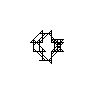

In [ ]:
MSvisualize(x[0])

In [ ]:
y[0]

tensor([0.4444])

Distribution of labels:

In [ ]:
ydata = torch.cat([data.data[i][1].squeeze() for i in range(len(data.data))])
ndata = torch.round(5.0 * ydata / (1.0 - ydata))
nmax = ndata.max().int().item()
ndistribution = [torch.where(ndata == i, 1.0, 0.0).mean().item() for i in range(nmax + 1)]

In [ ]:
ydata.mean(), ydata.std(), ydata.min(), ydata.max()

(tensor(0.5009), tensor(0.2270), tensor(0.), tensor(0.8649))

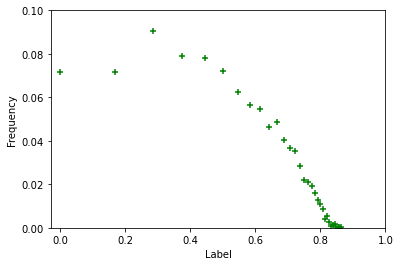

In [ ]:
plt.scatter([y / (y + 5) for y in range(nmax + 1)], ndistribution, color='green', marker = '+')
plt.xlabel('Label')
plt.ylabel('Frequency')
plt.xlim(-0.03, 1)
plt.ylim(0, 0.1)
plt.show()

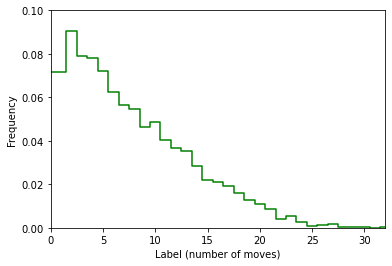

In [ ]:
plt.step(np.array(range(nmax + 1)), ndistribution, where='mid', color='green')
plt.xlabel('Label (number of moves)')
plt.ylabel('Frequency')
plt.xlim(0, nmax)
plt.ylim(0, 0.1)
# plt.savefig('labels_counting.png', bbox_inches='tight')
plt.show()

### Accuracy

The accuracy is computed after inverting the relation between the label $y$ and the corresponding number of moves $N$:
$$
N = \frac{5 y}{1 - y}
$$

In [ ]:
def accuracy(outputs, labels):
    noutputs = torch.round(5.0 * outputs / (1.0 - outputs))
    nlabels = torch.round(5.0 * labels / (1.0 - labels))
    return torch.where(noutputs == nlabels, 1.0, 0.0).mean()

In [ ]:
def plusminusone(outputs, labels):
    noutputs = torch.round(5.0 * outputs / (1.0 - outputs))
    nlabels = torch.round(5.0 * labels / (1.0 - labels))
    return torch.where(noutputs - nlabels < 1.5, 1.0, 0.0).mean()

## Model and training

**Transfer learning**: instead of training the model from scratch, use a template

In [ ]:
template = torch.load('models/Descartes_binary.pt')
template.train()
template

Sequential(
  (0): Conv2d(1, 20, kernel_size=(3, 3), stride=(3, 3), padding=(1, 1))
  (1): ReLU()
  (2): Conv2d(20, 40, kernel_size=(2, 2), stride=(1, 1))
  (3): ReLU()
  (4): Conv2d(40, 40, kernel_size=(2, 2), stride=(1, 1))
  (5): ReLU()
  (6): Conv2d(40, 40, kernel_size=(2, 2), stride=(1, 1))
  (7): ReLU()
  (8): Conv2d(40, 40, kernel_size=(2, 2), stride=(1, 1))
  (9): AdaptiveMaxPool2d(output_size=1)
  (10): Flatten(start_dim=1, end_dim=-1)
  (11): Linear(in_features=40, out_features=10, bias=True)
  (12): ReLU()
  (13): Linear(in_features=10, out_features=1, bias=True)
)

**Possible idea**: freeze all parameters of the template except for the bias of the last conv layer!

In [ ]:
for i in range(8):
    for param in template[i].parameters():
        param.requires_grad = False
for param in template[8].parameters():
    param.requires_grad = False
    break # break before the bias is frozen
template

Sequential(
  (0): Conv2d(1, 20, kernel_size=(3, 3), stride=(3, 3), padding=(1, 1))
  (1): ReLU()
  (2): Conv2d(20, 40, kernel_size=(2, 2), stride=(1, 1))
  (3): ReLU()
  (4): Conv2d(40, 40, kernel_size=(2, 2), stride=(1, 1))
  (5): ReLU()
  (6): Conv2d(40, 40, kernel_size=(2, 2), stride=(1, 1))
  (7): ReLU()
  (8): Conv2d(40, 40, kernel_size=(2, 2), stride=(1, 1))
  (9): AdaptiveMaxPool2d(output_size=1)
  (10): Flatten(start_dim=1, end_dim=-1)
  (11): Linear(in_features=40, out_features=10, bias=True)
  (12): ReLU()
  (13): Linear(in_features=10, out_features=1, bias=True)
)

In [ ]:
modules = [template[i] for i in range(9)]
modules.extend([torch.nn.ReLU(),
                torch.nn.AdaptiveAvgPool2d(1),
                torch.nn.Flatten(),
                torch.nn.Linear(40, 10),
                torch.nn.ReLU(),
                torch.nn.Linear(10, 1)])
net = torch.nn.Sequential(*modules)
net

Sequential(
  (0): Conv2d(1, 20, kernel_size=(3, 3), stride=(3, 3), padding=(1, 1))
  (1): ReLU()
  (2): Conv2d(20, 40, kernel_size=(2, 2), stride=(1, 1))
  (3): ReLU()
  (4): Conv2d(40, 40, kernel_size=(2, 2), stride=(1, 1))
  (5): ReLU()
  (6): Conv2d(40, 40, kernel_size=(2, 2), stride=(1, 1))
  (7): ReLU()
  (8): Conv2d(40, 40, kernel_size=(2, 2), stride=(1, 1))
  (9): ReLU()
  (10): AdaptiveAvgPool2d(output_size=1)
  (11): Flatten(start_dim=1, end_dim=-1)
  (12): Linear(in_features=40, out_features=10, bias=True)
  (13): ReLU()
  (14): Linear(in_features=10, out_features=1, bias=True)
)

In [ ]:
# modules = [template[i] for i in range(8)]
# modules.extend([torch.nn.Conv2d(40, 40, stride = 1, kernel_size = 2, padding = 0),
#                 torch.nn.ReLU(),
#                 torch.nn.AdaptiveAvgPool2d(1),
#                 torch.nn.Flatten(),
#                 torch.nn.Linear(40, 1)])
# net = torch.nn.Sequential(*modules)
# net

In [ ]:
# modules = [template[i] for i in range(8)]
# modules.extend([torch.nn.Conv2d(40, 20, stride = 1, kernel_size = 2, padding = 0),
#                 torch.nn.ReLU(),
#                 torch.nn.AdaptiveAvgPool2d(1),
#                 torch.nn.Flatten(),
#                 torch.nn.Linear(20, 10),
#                 torch.nn.ReLU(),
#                 torch.nn.Linear(10, 1)])
# net = torch.nn.Sequential(*modules)
# net

In [ ]:
y_pred = net(x)
y_pred.shape

torch.Size([200, 1])

In [ ]:
accuracy(y_pred, y)

tensor(0.0600)

## Training

In [ ]:
running_loss_data = []
accuracy_data = []

**WARNING**: I'm trying a learning rate of 0.02, twice the previous one

In [ ]:
data.train_model(net, n_epochs = 100, lr=0.02, accuracy_func = accuracy,
                 loss_monitoring = running_loss_data,
                 accuracy_monitoring = accuracy_data)

In [ ]:
# torch.save(net, 'models/Descartes.pt')

In [ ]:
data.info()

Number of mini-batches stored: 100
Number of mini-batches created: 112


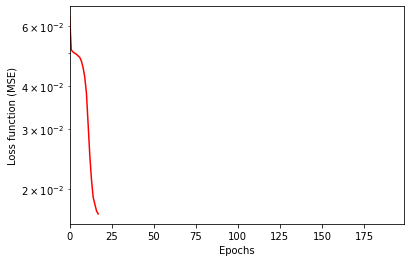

In [ ]:
plt.plot(running_loss_data, color='red')
plt.xlabel('Epochs')
plt.xlim(0, 199)
plt.ylabel('Loss function (MSE)')
plt.yscale('log')
# plt.savefig('xxx.png', bbox_inches='tight')
plt.show()

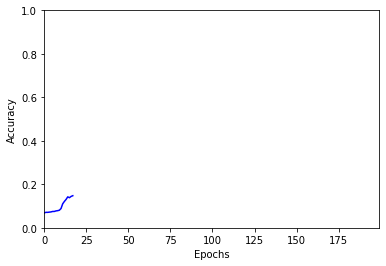

In [ ]:
plt.plot(accuracy_data, color='blue')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.xlim(0, 199)
plt.ylim(0, 1)
# plt.savefig('xxx.png', bbox_inches='tight')
plt.show()

In [ ]:
error_data = [1.0 - x for x in accuracy_data]

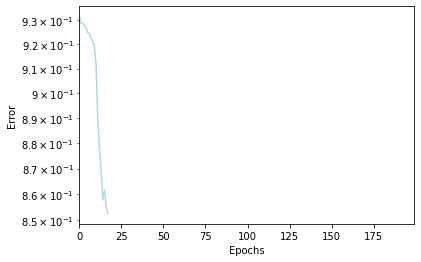

In [ ]:
plt.plot(error_data, color='lightblue')
plt.xlabel('Epochs')
plt.xlim(0, 199)
plt.ylabel('Error')
plt.yscale('log')
plt.show()

## Loading the model

Once the model has been trained, this can be used to load its state dictionary:

In [ ]:
# net2 = torch.load('models/Descartes_binary.pt')
# net2.eval()

## Validation

In [ ]:
x, y = generate_batch(1000)

In [ ]:
y_preds = net(x).data

In [ ]:
accuracy(y_preds, y)

tensor(0.1930)

In [ ]:
plusminusone(y_preds, y)

tensor(0.6560)

In [ ]:
y.mean(), y.std(), y_preds.mean(), y_preds.std()

(tensor(0.5188), tensor(0.2204), tensor(0.5612), tensor(0.1776))

In [ ]:
# mistakes = []
# for i in range(y.shape[0]):
#     if (y_preds[i] > 0.5) != y[i]:
#         mistakes.append([i, y[i].item(), y_preds[i].item()])
# mistakes

In [ ]:
# MSvisualize(x[mistakes[0][0]])